In [1]:
from contextlib import contextmanager
from dataclasses import dataclass
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

from c_tictactoe_py import TicTacToeEnvPy, Settings

In [2]:
@contextmanager
def time_block(label: str, timing_dict: dict[str, float]):
    start_time = time.time()
    yield
    end_time = time.time()
    timing_dict[label] = end_time - start_time

In [3]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torch.nn.Sequential(
            layer_init(torch.nn.Linear(18, 120)),
            torch.nn.LayerNorm(120),
            torch.nn.ReLU(),
            layer_init(torch.nn.Linear(120, 84)),
            torch.nn.LayerNorm(84),
            torch.nn.ReLU(),
            layer_init(torch.nn.Linear(84, 9)),
        )

    def forward(self, x):
        return self.network(x)

In [4]:
@dataclass
class Params:
    num_iterations: int
    lr: float
    gamma: float
    q_lambda: float
    num_envs: int
    num_steps: int
    model_device: str
    training_device: str
    update_epochs: int
    batch_size: int
    num_eval_steps: int
    start_epsilon: float
    end_epsilon: float
    epsilon_end_fraction: float

In [5]:
def eval(model: MLP, env: TicTacToeEnvPy, params: Params) -> float:
    rewards = np.zeros((params.num_envs, params.num_eval_steps))
    with torch.no_grad():
        states, _ = env.reset_all()
        for i in range(params.num_eval_steps):
            state_tensor = torch.tensor(states, device=params.model_device, dtype=torch.float32)
            actions = model(state_tensor).max(1).indices.flatten().numpy(force=True).astype(np.int16)
            states, reward, done, _ = env.step(actions)
            rewards[:, i] = reward
        r = np.mean(rewards)
        return r

In [6]:
def get_epsilon(params: Params, iteration: int):
    slope = (params.end_epsilon - params.start_epsilon) / (params.epsilon_end_fraction * params.num_iterations)
    return max(slope * iteration + params.start_epsilon, params.end_epsilon)

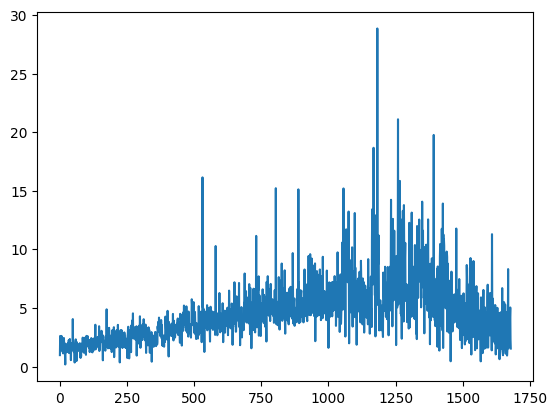

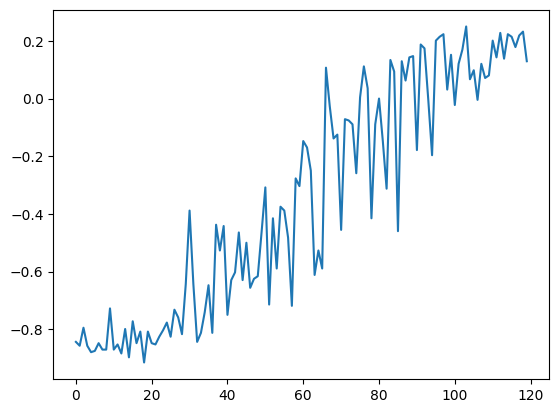

{'device_switch': 0.0, 'evaluation': 0.0029997825622558594, 'rollout': 0.005000591278076172, 'q_lambda': 0.0009996891021728516, 'optimize': 0.0280001163482666}


In [10]:
params = Params(
    num_iterations=120,
    lr=2e-4,
    gamma=0.99,
    q_lambda=0.65,
    num_envs=14,
    num_steps=14,
    model_device="cpu",
    training_device="cpu",
    update_epochs=2,
    batch_size=32,
    num_eval_steps=16,
    start_epsilon=1.0,
    end_epsilon=0.1,
    epsilon_end_fraction=0.5,
)   
vec_env = TicTacToeEnvPy(Settings(batch_size=params.num_envs))
observations, _ = vec_env.reset_all()
q_network = MLP().to(params.model_device)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=params.lr, amsgrad=True)
steps_done = 0
losses = []
evals = []
timing_data = {}

obs = torch.zeros((params.num_steps + 1, params.num_envs, 18)).to(params.training_device)
actions = torch.zeros((params.num_steps, params.num_envs, 1)).to(params.training_device)
rewards = torch.zeros((params.num_steps, params.num_envs)).to(params.training_device)
dones = torch.zeros((params.num_steps + 1, params.num_envs)).to(params.training_device)
values = torch.zeros((params.num_steps, params.num_envs)).to(params.training_device)
returns = torch.zeros_like(rewards).to(params.training_device)

for iteration in range(params.num_iterations):
    with time_block("device_switch", timing_data):
        q_network.eval()
        q_network.to(params.model_device)
    # Eval
    with time_block("evaluation", timing_data):
        evals.append(eval(q_network, vec_env, params))

    epsilon = get_epsilon(params, iteration)
    
    # Rollout
    with time_block("rollout", timing_data):
        done = torch.zeros(params.num_envs, dtype=torch.float32, device=params.training_device)
        for step in range(params.num_steps):
            steps_done += 1
            state_tensor = torch.tensor(observations, dtype=torch.float32, device=params.model_device)
            obs[step] = state_tensor
            dones[step] = done

            random_actions = torch.randint(0, 9, (params.num_envs,), device=params.model_device)
            with torch.inference_mode():
                q_values = q_network(state_tensor)
                policy_actions = torch.argmax(q_values, dim=1)
                values[step] = q_values[torch.arange(params.num_envs), policy_actions].flatten()
            
            explore_mask = torch.rand(params.num_envs, device=params.model_device) < epsilon
            action = torch.where(explore_mask, random_actions, policy_actions)
            actions[step] = action.unsqueeze(1)
            observations, reward, done, _ = vec_env.step(action.numpy(force=True).astype(np.int16))
            rewards[step] = torch.tensor(reward, dtype=torch.float32, device=params.training_device)
            done = torch.tensor(done, dtype=torch.float32, device=params.training_device)
        # add final observation
        next_obs = torch.tensor(observations, dtype=torch.float32, device=params.model_device)
        obs[-1] = next_obs
        dones[-1] = done
    
    # Train
    with time_block("device_switch", timing_data):
        q_network.train()
        q_network.to(params.training_device)
    # Q(lambda)
    with time_block("q_lambda", timing_data):
        with torch.no_grad():
            for t in reversed(range(params.num_steps)):
                if t == params.num_steps - 1:
                    next_value, _ = torch.max(q_network(next_obs.to(params.training_device)), dim=-1)
                    nextnonterminal = 1.0 - done
                    returns[t] = rewards[t] + params.gamma * next_value * nextnonterminal
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_value = values[t + 1]
                    returns[t] = rewards[t] + params.gamma * (
                        params.q_lambda * returns[t + 1] + (1 - params.q_lambda) * next_value * nextnonterminal
                    )

    with time_block("optimize", timing_data):
        # flatten the batch
        b_obs = obs.reshape((-1, 18))
        b_actions = actions.reshape((-1, 1))
        b_returns = returns.reshape(-1)

        # Optimize
        inds = np.arange(params.num_steps * params.num_envs)
        for epoch in range(params.update_epochs):
            np.random.shuffle(inds)
            for batch_start in range(0, params.num_steps * params.num_envs, params.batch_size):
                batch_inds = inds[batch_start : batch_start + params.batch_size]

                old_val = q_network(b_obs[batch_inds]).gather(1, b_actions[batch_inds].long()).squeeze()
                loss = torch.nn.functional.mse_loss(b_returns[batch_inds], old_val)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_network.parameters(), max_norm=10.0)
                optimizer.step()
                losses.append(loss.detach().cpu().numpy())

plt.plot(losses)
plt.show()
plt.plot(evals)
plt.show()
print(timing_data)

In [8]:
q_network(torch.zeros(1, 18, device=params.training_device))

tensor([[-13.0080, -12.1524, -12.6303, -13.0671, -13.0864, -12.9240, -13.1411,
         -13.2356, -13.4729]], grad_fn=<AddmmBackward0>)

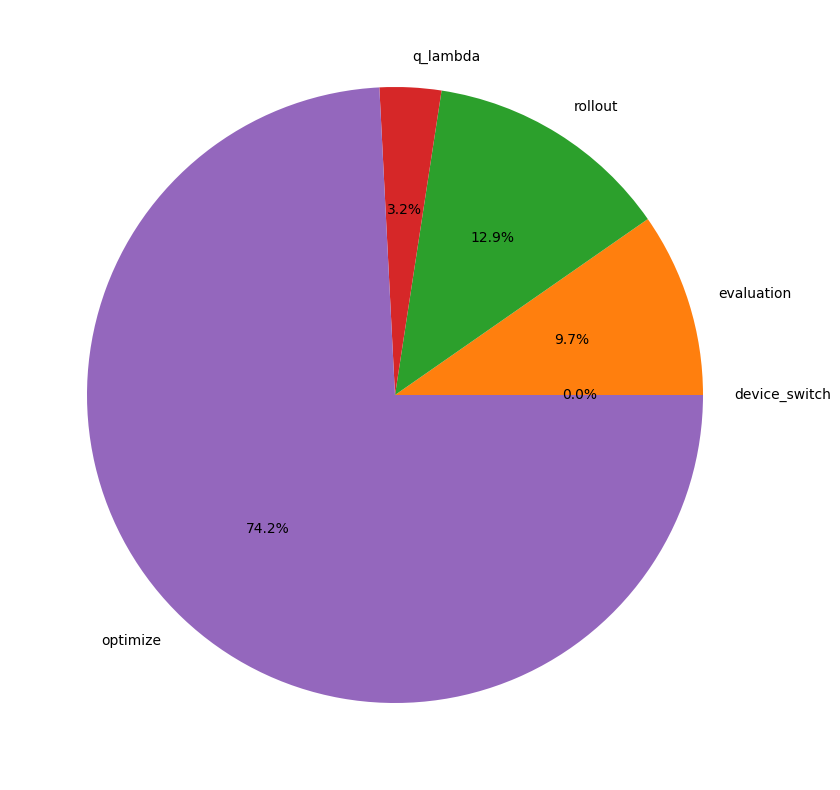

In [9]:
# cake diagram of timing data
plt.figure(figsize=(10, 10))
plt.pie(timing_data.values(), labels=timing_data.keys(), autopct="%1.1f%%")
plt.show()